### Characterization of Enamel structure by 4D-STEM

- This is a series of scripts to analyze 4DSTEM data of Enamel samples acquired using K3-IS synchronized with STEMx
- Microscope: JEOL ARM300F operated at 300kV


In [1]:
%matplotlib nbagg
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from py4DSTEM.process.braggdiskdetection import get_average_probe_from_ROI, get_probe_kernel_subtrgaussian
from py4DSTEM.process.utils import get_CoM
from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.io import read, save

**DataSet #1**

- Experimental scan dimensions: [133,131,256,256]

In [2]:
filename = 'Bin(2,2,2, 2) of outer enamel (perpendicular).dm4'
datacube = py4DSTEM.file.io.read(filename)

Bin(2,2,2, 2) of outer enamel (perpendicular).dm4 is not a py4DSTEM file.
Couldn't identify input, attempting to read with hyperspy...


In [3]:
datacube.data.shape

(132, 300, 256, 256)

In [4]:
# Setting scan shapes(need the experimental scan dimensions)
datacube.set_scan_shape(132,300)
datacube.name = 'datacube'

**Generate virtual images**

1. Create virtual masks using average diffraction

<IPython.core.display.Javascript object>


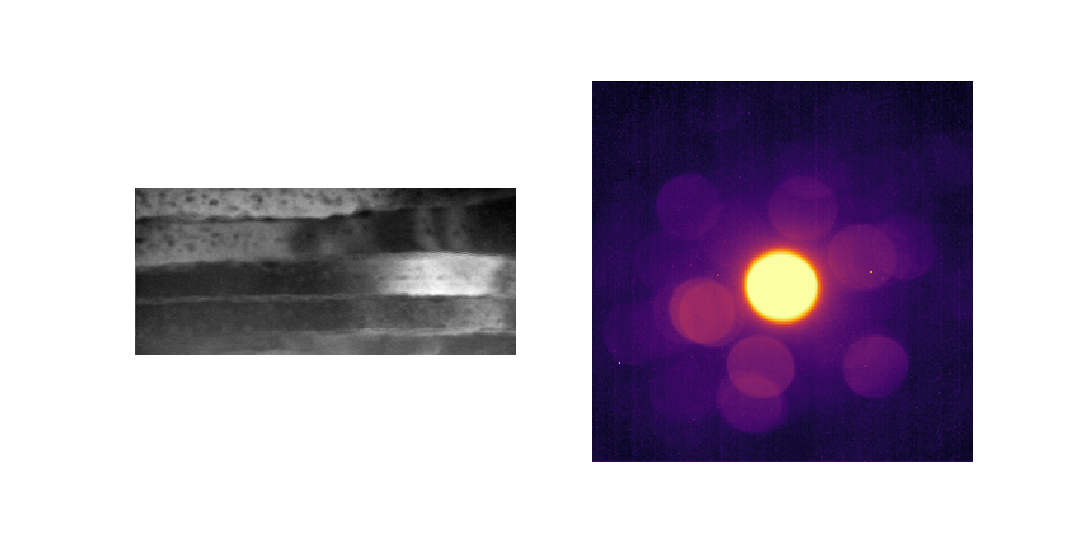

In [5]:
#take average diffraction pattern accross whole area
aveDP = np.average(datacube.data, axis=(0,1))

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(6,3))

#plot real space image
ax1.matshow(np.average(datacube.data, axis=(2,3)))

#plot sqrt of average diffraciton pattern 
ax2.matshow(np.sqrt(aveDP), cmap=plt.cm.inferno)

ax1.axis('off')
ax2.axis('off')

plt.show()

In [6]:
realimage=np.average(datacube.data, axis=(2,3))

#y_height=101
y_height=100

xreal=np.arange(15, 285, 30)
yreal=y_height*np.ones(9)

radius=8

output=[]
#integrae from summed vectors

for k in range(len(xreal)): 
    x, y = np.indices((realimage.shape[0], realimage.shape[1]))
    mask_circle1 = (yreal[k]-x) ** 2 + (xreal[k]-y) ** 2 < radius ** 2
    
    DP=np.zeros((datacube.data.shape[2],datacube.data.shape[3]))

    for i in range(0,realimage.shape[0]):
        for j in range(0,realimage.shape[1]): 
            if mask_circle1[i,j]: 
                DP=DP+datacube.data[i,j,:,:] 
    output.append(DP)

<IPython.core.display.Javascript object>


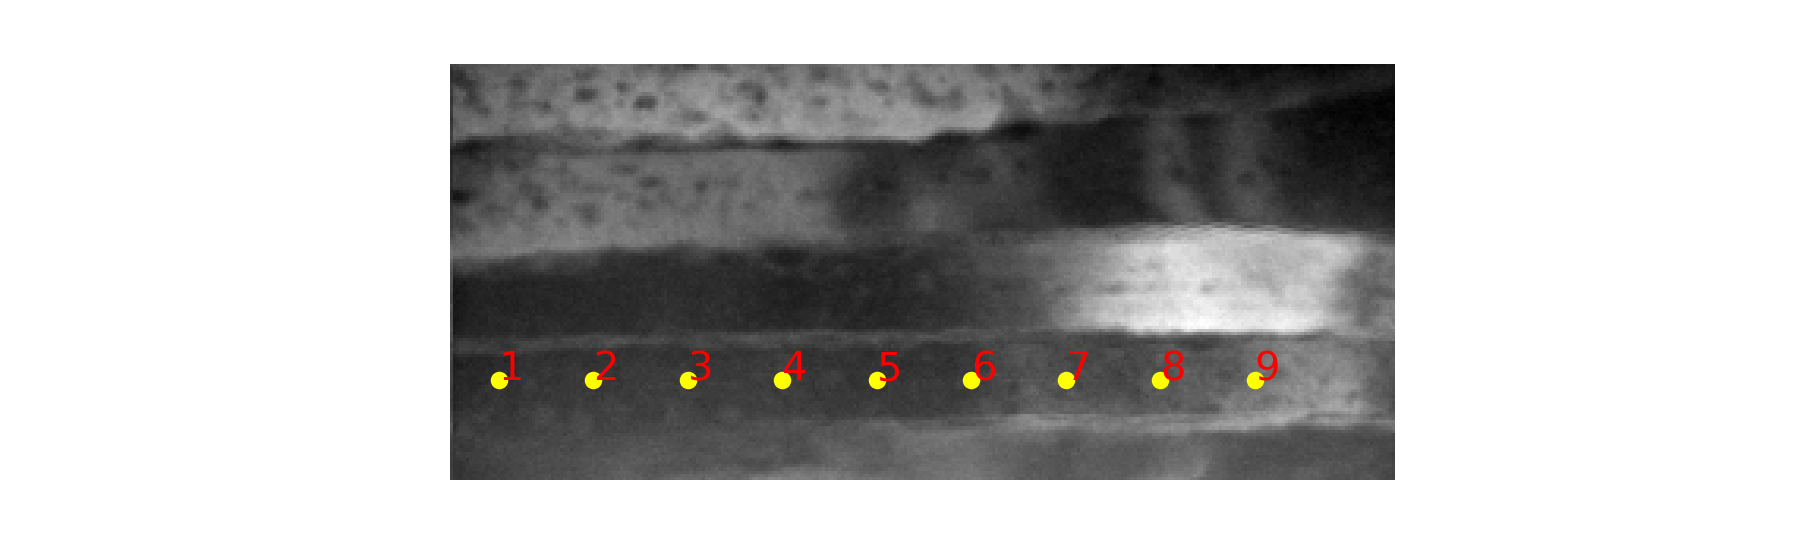

In [7]:
fig, axes = plt.subplots(figsize=(10,3))
axes.matshow(np.average(datacube.data, axis=(2,3)))
for xx, yy, labels in zip(xreal, yreal, range(1,12)): 
#    print(xx,yy,text)
    axes.text(xx,yy,str(labels), size=16, color="red")    
    axes.scatter(xx,yy, color='yellow')
axes.axis('off')
plt.show()

<IPython.core.display.Javascript object>


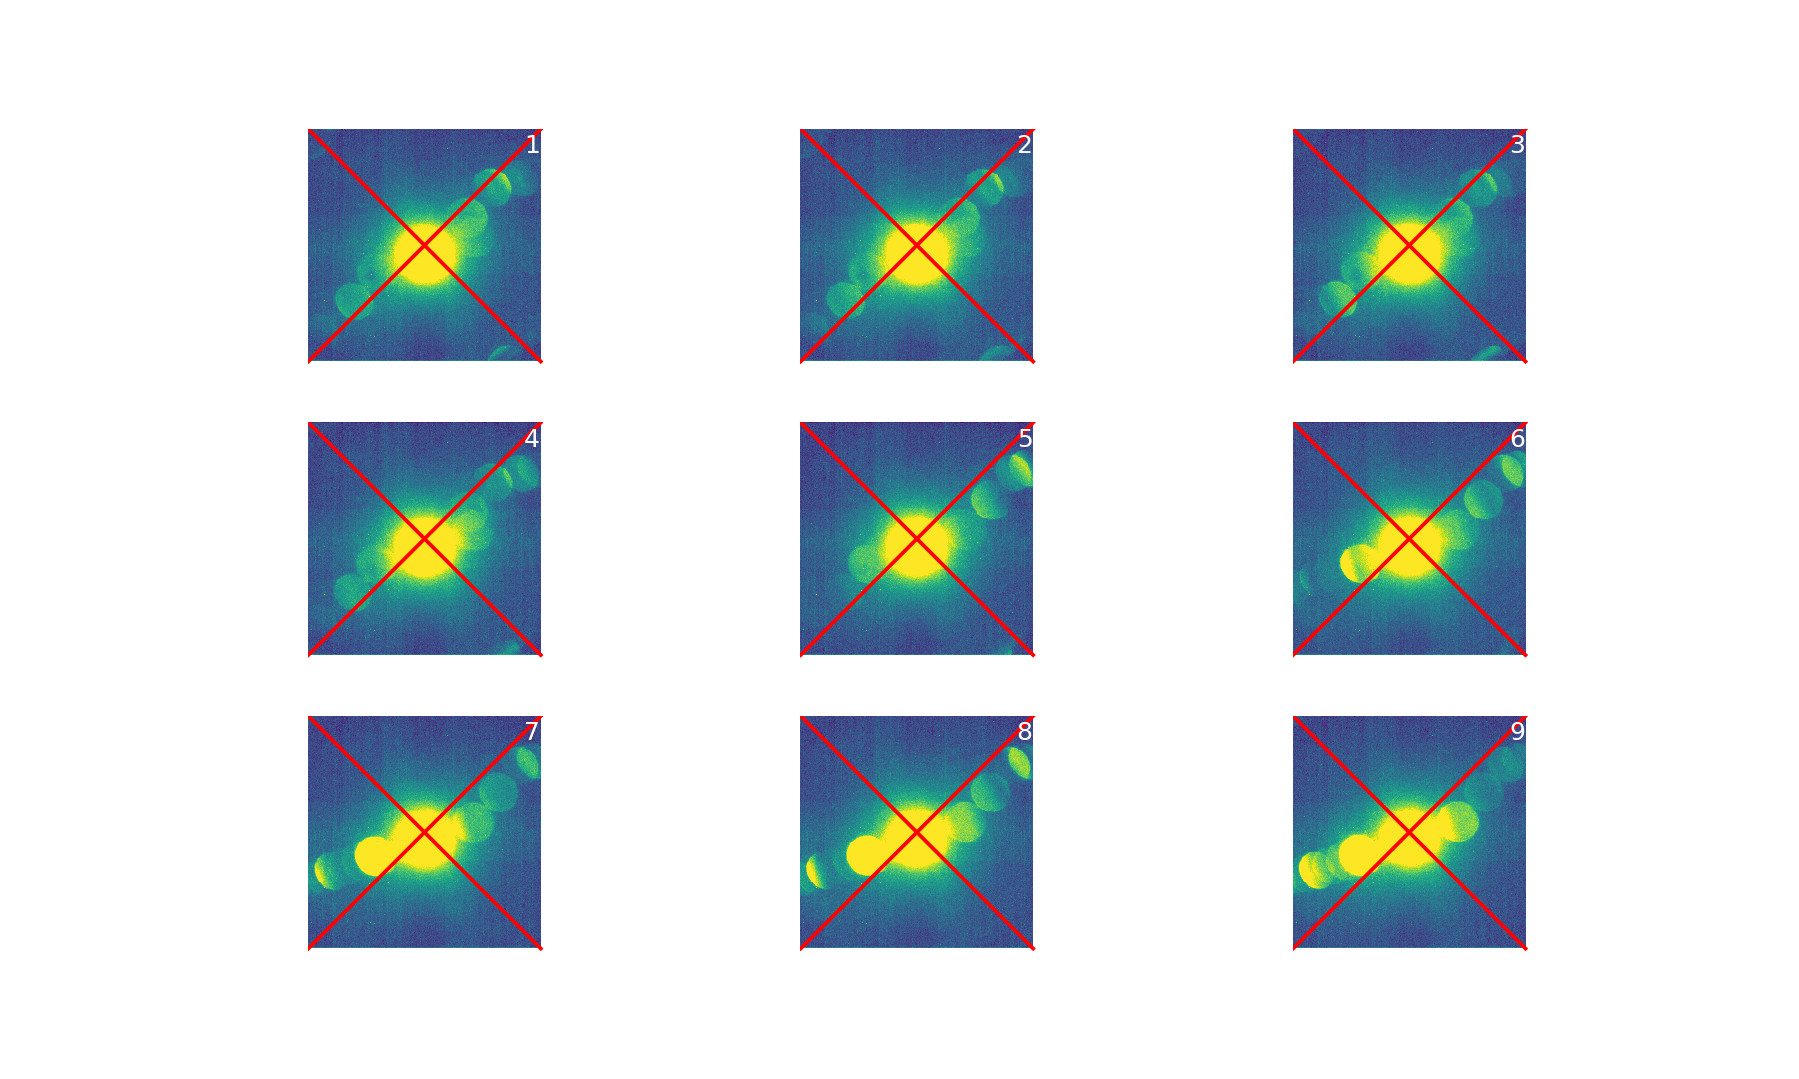

In [8]:
titles=[1,2,3,4,5,6,7,8,9]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,6))

for ax, feature, name in zip(axes.flatten(), output, titles):
    ax.imshow(np.sqrt(feature), cmap=plt.cm.viridis, vmax=110)
    #ax.set(title=name, x=0.9, y=0.9)
    ax.text(0.95, 0.9, name, transform=ax.transAxes, ha="right", color='white')
    ax.axis('off')
    ax.plot([0, 256], [256, 0], 'red')
    ax.plot([256, 0], [256, 0], 'red')
   # ax.scatter(xs, ys, c = 'red', s=0.5)
plt.show()

In [9]:
from skued.image import powder_center
ic, jc = powder_center(aveDP)

In [10]:
#we could use autodetect for finding the center of disks, but let's start with manual
xx=106
yy=218

pixel_rad=np.sqrt((xx-jc)**2+(yy-ic)**2)

<IPython.core.display.Javascript object>


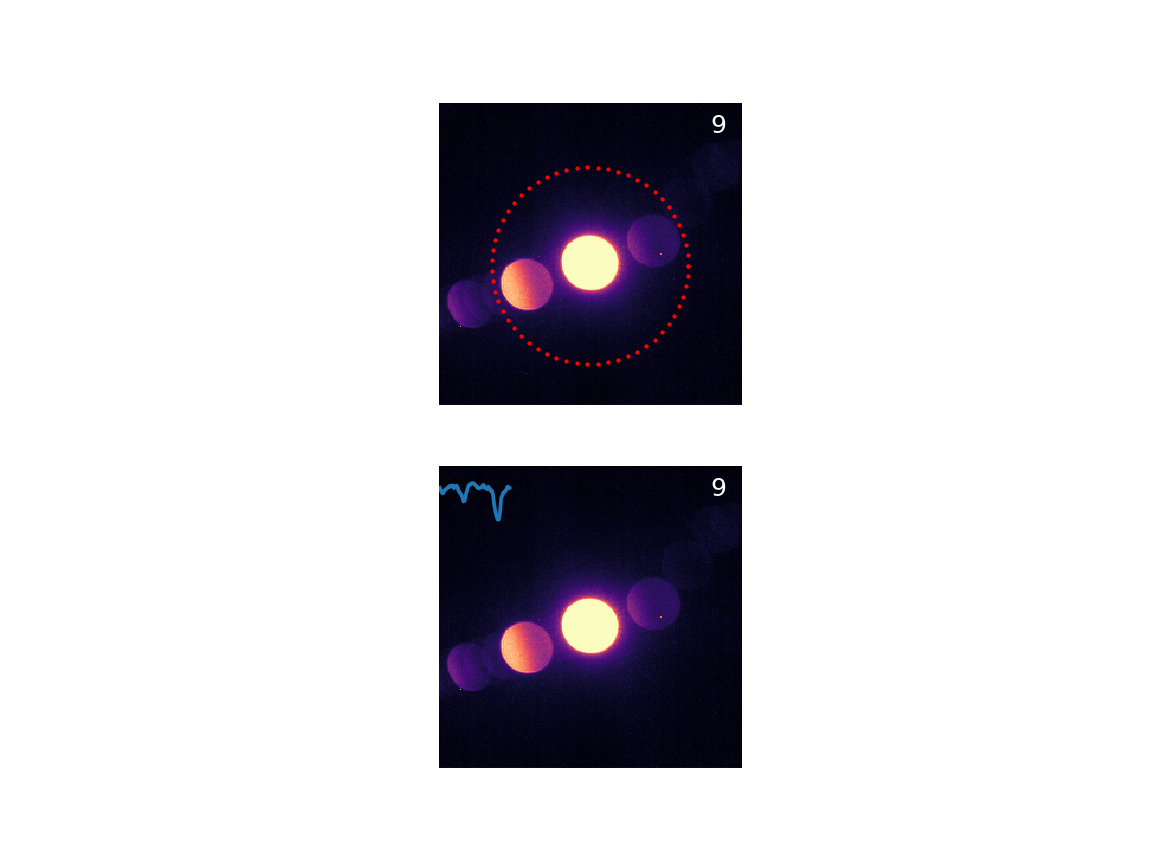

In [11]:
#image=np.average(datacube.data[50:51,50:51,:,:], axis=(0,1))

image=datacube.data[101,121,:,:]
#image=aveDP

n_dots = 60   # set number of dots
angs = np.linspace(0, 2*np.pi, n_dots)  # angles to the dots
cx, cy = (jc, ic)  # center of circle
xs, ys = [], []    # for coordinates of points to plot
ra = pixel_rad          # radius of circle

for ang in angs:
    # compute (x,y) for each point
    x = cx + ra*np.cos(ang)
    y = cy + ra*np.sin(ang)
    xs.append(x)   # collect x
    ys.append(y)   # collect y

xs=np.asarray(xs)
ys=np.asarray(ys)

zi=np.zeros((1,len(xs)))
for ii in range(0,len(xs)):
    zi[0,ii] = np.average(image[xs[ii].astype(np.int)-10:xs[ii].astype(np.int)+10, \
                               ys[ii].astype(np.int)-10:ys[ii].astype(np.int)+10])
    

fig, axes = plt.subplots(nrows=2)

axes[0].scatter(xs, ys, c = 'red', s=0.5)  # plot points 
axes[0].imshow(image, cmap= plt.cm.magma)

axes[1].plot(zi[0,:])

plt.show()


In [12]:
peak_max=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
remain=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

n_dots = 60   # set number of dots
angs = np.linspace(0, 2*np.pi, n_dots)  # angles to the dots
cx, cy = (jc, ic)  # center of circle
ra = pixel_rad 

aa=5
for i in range(0,datacube.data.shape[0]):
        for j in range(0,datacube.data.shape[1]): 
            #image=np.average(datacube.data[i-3:i+3,j-3:j+3,:,:], axis=(0,1))
            image=datacube.data[i,j,:,:]
            xs, ys = [], []    
      

            for ang in angs:
                x = cx + ra*np.cos(ang)
                y = cy + ra*np.sin(ang)
                xs.append(x)   
                ys.append(y)   

            xs=np.asarray(xs)
            ys=np.asarray(ys)

            zi=np.zeros((1,len(xs)))
            for ii in range(0,len(xs)):
                    zi[0,ii] = np.average(image[xs[ii].astype(np.int)-aa:xs[ii].astype(np.int)+aa, \
                               ys[ii].astype(np.int)-aa:ys[ii].astype(np.int)+aa])
            
            max_loc=np.argmax(zi)
            peak_max[i,j]=max_loc
            remain[i,j]=max_loc%30


<IPython.core.display.Javascript object>


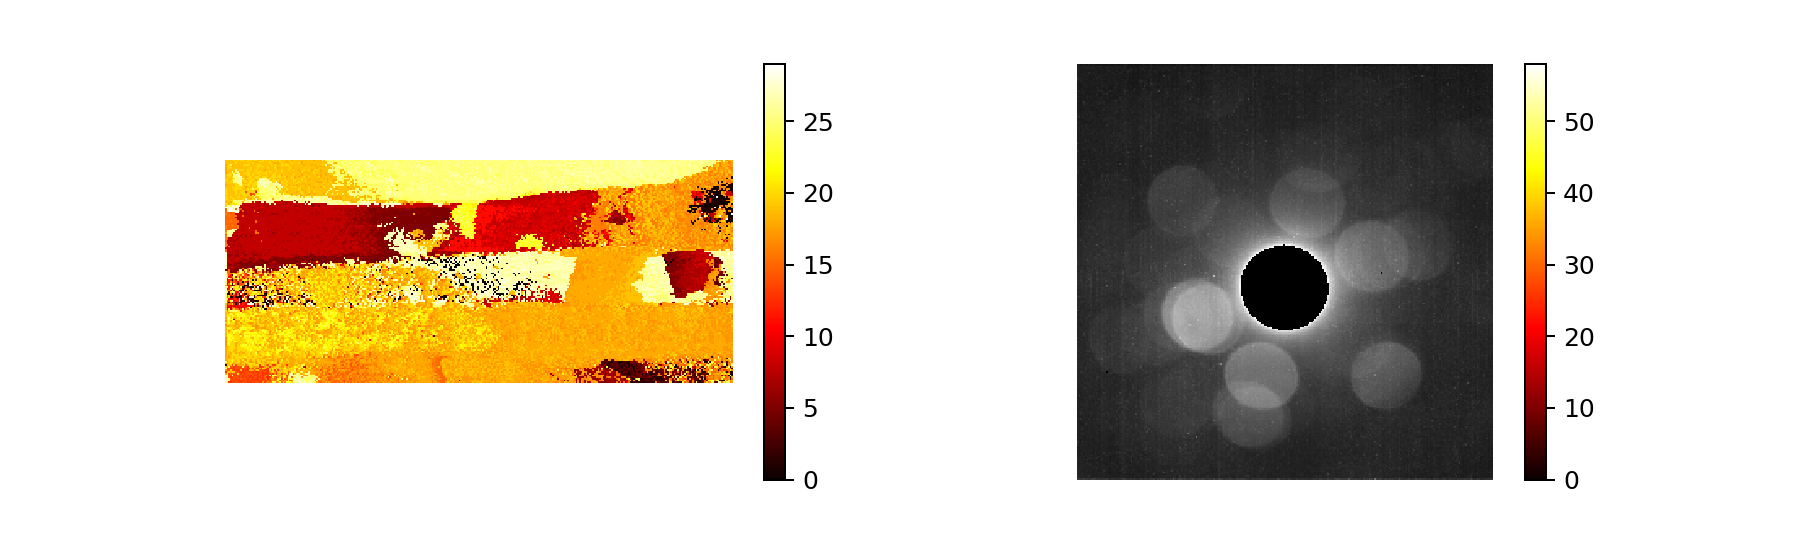

In [13]:
fig,axs = plt.subplots(1,2,figsize=(10,3))
map0=axs[0].imshow(remain, cmap=plt.cm.hot) 
fig.colorbar(map0, ax=axs[0])

map1=axs[1].imshow(peak_max, cmap=plt.cm.hot)  
fig.colorbar(map1)

axs[0].axis('off')
axs[1].axis('off')

plt.show()

In [14]:
from skued.image import powder_center
ic, jc = powder_center(aveDP)
print("ic is " + str(ic))
print("jc is " + str(jc))

ic is 137.5
jc is 127.0


<IPython.core.display.Javascript object>


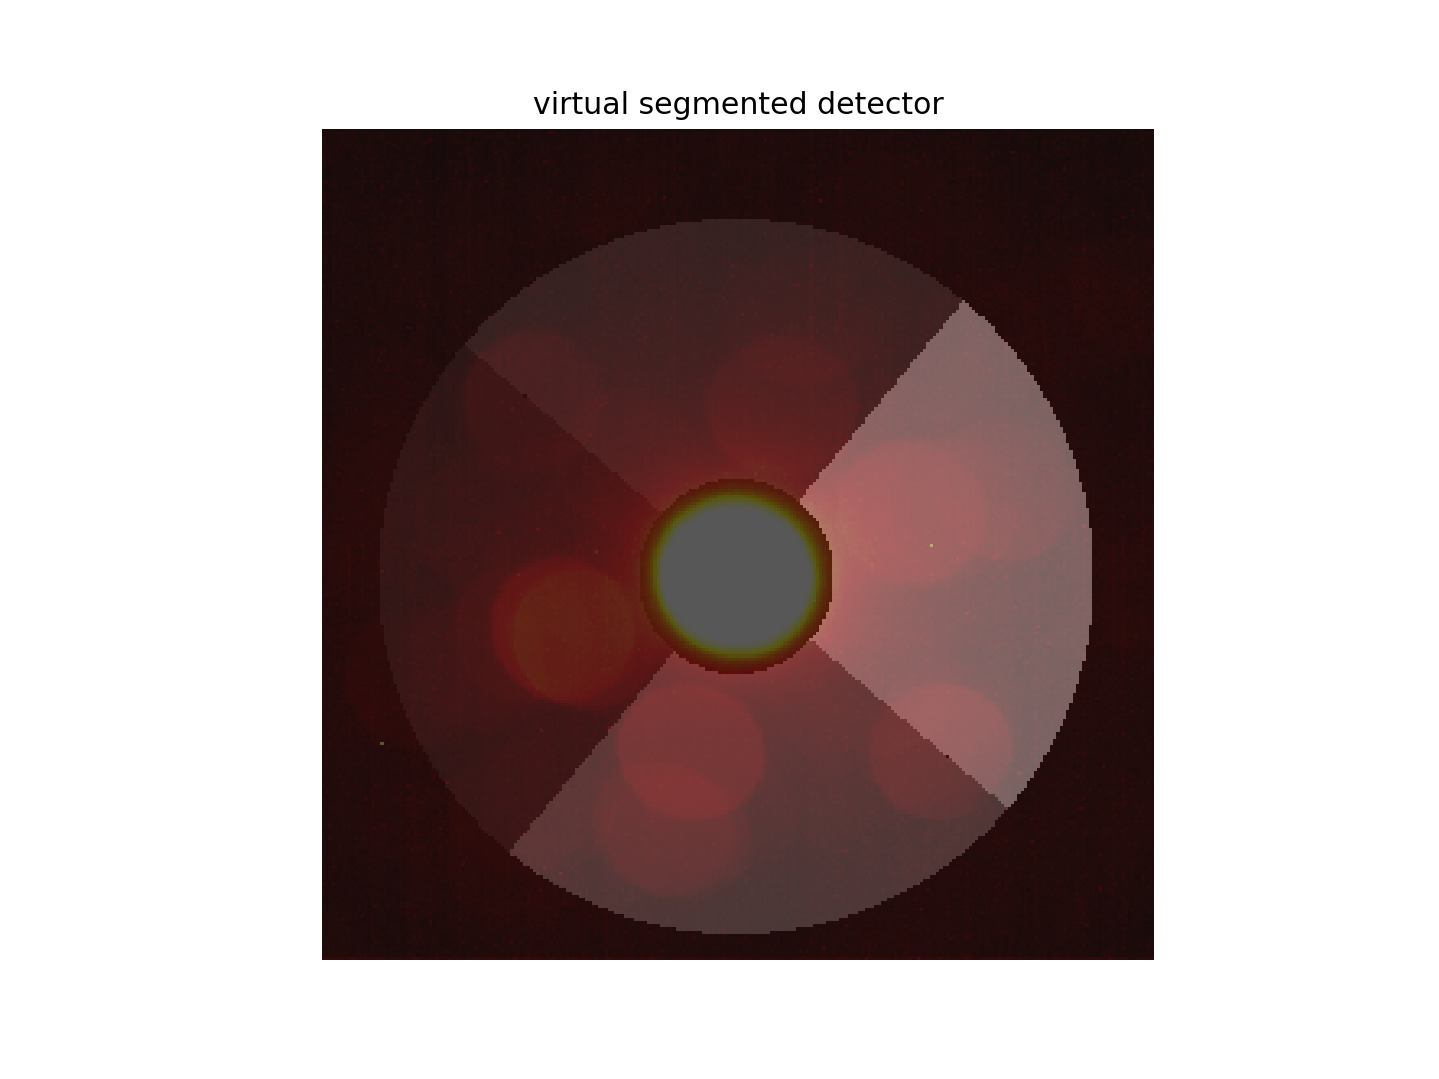

number of elements in mask1 is 8892
number of elements in mask2 is 8699
number of elements in mask3 is 8699
number of elements in mask4 is 8892


In [121]:
#make a quadrant mask defined by circle centered at origin of diffraciton (ic,jc)
xa, ya = 62, 82

#rotate point by 90° relative to ic, jc (going to use point-point form to define lines for masks)
theta = np.radians(90)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

v=np.array([[xa-ic],[xb-jc]])
v=np.dot(v.T,R).T
xb=v[0,0]+jc
yb=v[1,0]+ic

#create masks changing inequalities
x, y = np.indices((aveDP.shape[0], aveDP.shape[1]))
mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask1 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) < 0
mask2 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) < 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask3 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)

mask_circle = (x - ic) ** 2 + (y-jc) ** 2 < 110 ** 2
mask_circle2 = (x - ic) ** 2 + (y-jc) ** 2 > 30 ** 2
mask_line =  y - xa - (jc-xa)/(ic-ya) * (x-ya) > 0
mask_line_perpendicular =  y - xb - (jc-xb)/(ic-yb) * (x-yb) > 0
mask4 = np.logical_and(np.logical_and(np.logical_and(mask_circle, mask_line), mask_line_perpendicular), mask_circle2)

#plot masks
fig,ax = plt.subplots(figsize=(8,6))
ax.imshow(mask1, alpha=0.5)
ax.imshow(mask2, alpha=0.5)
ax.imshow(mask3, alpha=0.5)
ax.imshow(mask4, alpha=0.5)
ax.imshow(np.sqrt(aveDP), cmap=plt.cm.hot, alpha=0.3)
ax.set_title('virtual segmented detector')
ax.axis('off')
plt.show()

#check they are of equal area
print('number of elements in mask1 is ' + str(mask1.sum()))
print('number of elements in mask2 is ' + str(mask2.sum()))
print('number of elements in mask3 is ' + str(mask3.sum()))
print('number of elements in mask4 is ' + str(mask4.sum()))

In [126]:
int_mask1=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask2=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask3=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))
int_mask4=np.zeros((datacube.data.shape[0],datacube.data.shape[1]))

for i in range(0,aveDP.shape[0]):
    for j in range(0,aveDP.shape[1]): 
            if mask1[i,j]:
                int_mask1=int_mask1+datacube.data[:,:,i,j] 
            if mask2[i,j]:
                int_mask2=int_mask2+datacube.data[:,:,i,j] 
            if mask3[i,j]:
                int_mask3=int_mask3+datacube.data[:,:,i,j] 
            if mask4[i,j]:
                int_mask4=int_mask4+datacube.data[:,:,i,j] 

<IPython.core.display.Javascript object>


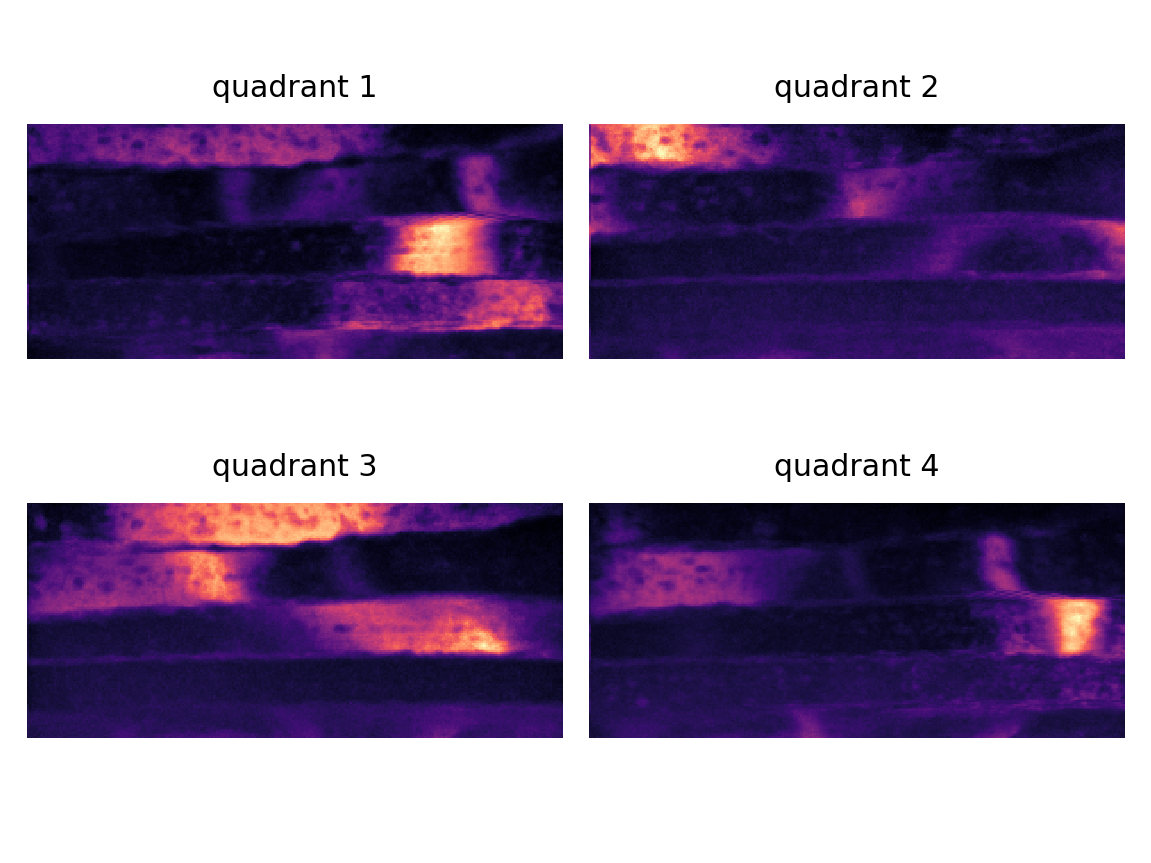

In [149]:
fig, ax = plt.subplots(2,2)
ax[0,0].matshow(int_mask1, cmap=plt.cm.magma)
ax[0,1].matshow(int_mask2, cmap=plt.cm.magma)
ax[1,0].matshow(int_mask3, cmap=plt.cm.magma)
ax[1,1].matshow(int_mask4, cmap=plt.cm.magma)

list1=[1,2,3,4]

for ax, num in zip(ax.flatten(), list1):
    ax.axis('off')
    ax.set_title('quadrant ' + str(num))
plt.tight_layout()
plt.show()